In [9]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [10]:
# Declare the credentials
client_id = '649415c71a4b4f94a9007dadfc83de96'
client_secret = 'c8617cff2e5e4d3985ace0b1f1a3531d'
redirect_uri='http://localhost:7777/callback'
username = 'ethan.falcao'
#"383yg3vhnzhume0s2ug7p5y26' is Nur's account 


In [11]:
# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [12]:
# # Getting playlist IDs from each of Spotify's playlists
playlists = sp.user_playlists('spotify')
spotify_playlist_ids = []
while playlists:
    for i, playlist in enumerate(playlists['items']):
        spotify_playlist_ids.append(playlist['uri'][-22:])
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None
spotify_playlist_ids[:20]
#change 5 to 20

['37i9dQZF1DXcBWIGoYBM5M',
 '37i9dQZF1DX0XUsuxWHRQd',
 '37i9dQZF1DX1lVhptIYRda',
 '37i9dQZF1DX10zKzsJ2jva',
 '37i9dQZF1DX4JAvHpjipBk',
 '37i9dQZF1DX4sWSpwq3LiO',
 '37i9dQZF1DX4SBhb3fqCJd',
 '37i9dQZF1DWXRqgorJj26U',
 '37i9dQZF1DX4dyzvuaRJ0n',
 '37i9dQZF1DXcF6B6QPhFDv',
 '37i9dQZF1DWXJfnUiYjUKT',
 '37i9dQZF1DXcRXFNfZr7Tp',
 '37i9dQZF1DX4o1oenSJRJd',
 '37i9dQZF1DXbTxeAdrVG2l',
 '37i9dQZF1DX4UtSsGT1Sbe',
 '37i9dQZF1DWTJ7xPn4vNaz',
 '37i9dQZF1DXaKIA8E7WcJj',
 '37i9dQZF1DWSV3Tk4GO2fq',
 '37i9dQZF1DWTwnEm1IYyoj',
 '37i9dQZF1DX2A29LI7xHn1']

In [13]:
len(spotify_playlist_ids)

1108

In [14]:
#Getting tracks from Spotify playlists
# Creating a function to get the first 50 tracks IDs from a playlist
def getTrackIDs(playlist_id):
    try:
        playlist = sp.playlist(playlist_id)
        for item in playlist['tracks']['items'][:100]:
            track = item['track']
            ids.append(track['id'])
    except Exception as e:
        print(f"Error fetching playlist {playlist_id}: {e}")
#change 100 to 50

In [15]:
# %%time
# # Gathering track ids
ids = []
for x in spotify_playlist_ids[:210]:
    getTrackIDs(x)
ids[:5]
#change 50 to 200

Error fetching playlist 37i9dQZF1DX2RxBh64BHjQ: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DXc0fQ4sGOnVJ: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DWUzFXarNiofw: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DXcZDD7cfEKhW: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DXa41CMuUARjl: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DX5GiUwx1edLZ: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DWV0gynK7G6pD: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DWYHkSks5rujC: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DWZreqadA03A8: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DXdwF9DytRe8w: 'NoneType' object is not subscriptable


['3rUGC1vUpkDG9CZFHMur1t',
 '7aqfrAY2p9BUSiupwk3svU',
 '7dJYggqjKo71KI9sLzqCs8',
 '4MjDJD8cW7iVeWInc2Bdyj',
 '5aIVCx5tnk0ntmdiinnYvw']

In [16]:
len(ids)

14878

In [ ]:
#don't run  

In [54]:
def fetch_audio_features(sp, track_ids):
    # Make the API request
    audio_features = []
    index = 0
    while index < len(track_ids):
        audio_features += sp.audio_features(track_ids[index:index + 70])
        index += 70
    
    # Create an empty list to feed in different characteristics of the tracks
    features_list = []
        
    for track_id, features in zip(track_ids, audio_features):
        features_list.append([
        track_id,
        features['time_signature'], 
        features['danceability'],
        features['acousticness'],
        features['energy'],
        features['tempo'],
        features['instrumentalness'],
        features['loudness'],
        features['liveness'],
        features['duration_ms'],
        features['key'],
        features['valence'],
        features['speechiness'],
        features['mode']
    ])

    df_audio_features = pd.DataFrame(features_list, columns=['track_id','duration_ms','time_signature', 'danceability', 'acousticness', 'energy', 'tempo', 
                                                             'instrumentalness', 'loudness', 'liveness', 'key',
                                                             'valence', 'speechiness', 'mode'])
    
    return df_audio_features

In [75]:
ids_features =  fetch_audio_features(sp, ids)
ids_features.head()

,track_id,duration_ms,time_signature,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,key,valence,speechiness,mode
0,3rUGC1vUpkDG9CZFHMur1t,1,0.750,0.2560,0.733,111.018,0.000000,-3.180,0.114,131872,6,0.844,0.0319,0
1,7aqfrAY2p9BUSiupwk3svU,4,0.470,0.0277,0.640,163.920,0.000000,-7.779,0.382,247444,2,0.248,0.3200,1
2,7dJYggqjKo71KI9sLzqCs8,4,0.750,0.2280,0.674,123.026,0.000089,-6.128,0.122,265360,8,0.392,0.0970,0
3,4MjDJD8cW7iVeWInc2Bdyj,4,0.787,0.1500,0.621,139.056,0.000402,-5.009,0.580,267194,4,0.130,0.0680,0
4,5aIVCx5tnk0ntmdiinnYvw,4,0.673,0.0856,0.722,117.187,0.000000,-3.495,0.137,200256,3,0.519,0.0755,0


In [74]:
#Export to csv
ids_features.to_csv('/Users/ethan/Documents/Spotify_recommendations/Github_pull/github/Spotify_Reccommendation_Algorithm/14k_features_ids.csv', index=False)

In [ ]:
#dont run above

In [ ]:
# Due to Rate limiting Split the list into smaller batches of 2,000 IDs each
batch_size = 2000
ids_lists = [ids[i:i + batch_size] for i in range(0, len(ids), batch_size)]

# Iterate throught the list of list and get the feature of each song id 
song_info = []
# Iterate through each list of song IDs
for song_id_list in ids_lists:
    for song_id in song_id_list:
        try:
            # Search for the track using its ID
            track = sp.track(song_id)
            song_name = track['name']
            # Get the artists as a list of dictionaries and extract their names
            artists = [artist['name'] for artist in track['artists']]
            song_info.append({'ID': song_id, 'Song Name': song_name, 'Artists': artists})
        except:
            time.sleep(0.5)
            song_info.append({'ID': song_id, 'Song Name': 'Not Found'})
            song_id_list.remove(song_id)  # Remove the song ID from the current list
            pass
# Create a DataFrame from the collected song information
song_df = pd.DataFrame(song_info)


In [17]:
#song_ids = ids[:5000]
#song_ids = ids[5000:10000]
song_ids = ids[10000:]


In [18]:
song_info = []

for song_id in song_ids:
    try:
        # Search for the track using its ID
        track = sp.track(song_id)
        song_name = track['name']
        # Get the album name
        album_name = track['album']['name']
        # Get the artists a
        artists = [artist['name'] for artist in track['artists']]
        popularity = track['popularity']
        song_info.append({'ID': song_id, 
                          'Song Name': song_name, 
                          'Artists': artists, 
                          'Album Name': album_name, 
                          'Popularity': popularity})
    except:
        time.sleep(.5)
        song_info.append({'ID': song_id, 'Song Name': 'Not Found'})
        song_ids.remove(song_id)
        pass

song_df = pd.DataFrame(song_info)
song_df    

,ID,Song Name,Artists,Album Name,Popularity
0,6q41rWOFtGs0K63lm0tAPa,Simply Won't Do,[Disclosure],Alchemy,56
1,3srre2C7GNHuowM46tOe1J,On My Mind,[Nic Fanciulli],On My Mind,35
2,0HfwmVJGd0kzoVXLB6g7cX,WTF,"[Dale Howard, Roland Clark]",WTF,43
3,6As1zfxQHAgeQPBK2paaqh,The Greatest Thing Alive,"[Mark Knight, Green Velvet, James Hurr]",The Greatest Thing Alive,47
4,5LZNaPmgnxH2YHwmU9G0GL,Its Time to Move,[Sosa UK],Its Time to Move,51
...,...,...,...,...,...
4873,6ZSTinOwx5dKFYc6iYyGDn,Leaving on a Jet Plane,"[Peter, Paul and Mary]",Album 1700,62
4874,4DKRLDVRIGojztAOEdvmXK,I Put A Spell On You,[Nina Simone],The Best Of Nina Simone,0
4875,0OwvrdjaJOypNsNQHyBWE5,California Soul,[Marlena Shaw],The Spice Of Life,69
4876,3IKyTBHZSgCx2v1ZX8v0TZ,Albatross - 2018 Remaster,[Fleetwood Mac],The Pious Bird of Good Omen,0


In [19]:
song_df.to_csv('/Users/ethan/Documents/Spotify_recommendations/Github_pull/github/Spotify_Reccommendation_Algorithm/15k_info.csv', index=False)

In [33]:
df_5k=pd.read_csv('/Users/ethan/Documents/Spotify_recommendations/Github_pull/github/Spotify_Reccommendation_Algorithm/data/5k_info.csv', sep=",")
df_10k=pd.read_csv('/Users/ethan/Documents/Spotify_recommendations/Github_pull/github/Spotify_Reccommendation_Algorithm/data/10k_info.csv', sep=",")
df_15k=pd.read_csv('/Users/ethan/Documents/Spotify_recommendations/Github_pull/github/Spotify_Reccommendation_Algorithm/data/15k_info.csv', sep=",")
df_features=pd.read_csv('/Users/ethan/Documents/Spotify_recommendations/Github_pull/github/Spotify_Reccommendation_Algorithm/data/14k_features_ids.csv', sep=",")

In [54]:
df_info = pd.concat([df_5k, df_10k, df_15k])
df_info = df_info.rename(columns={'ID': 'track_id',
                                  'Song Name': 'Song',
                                  'Album Name': 'Album'                                
                                  })
df_info.head()

,track_id,Song,Artists,Album,Popularity
0,3rUGC1vUpkDG9CZFHMur1t,greedy,['Tate McRae'],greedy,98
1,7aqfrAY2p9BUSiupwk3svU,First Person Shooter (feat. J. Cole),"['Drake', 'J. Cole']",For All The Dogs,91
2,7dJYggqjKo71KI9sLzqCs8,Agora Hills,['Doja Cat'],Scarlet,89
3,4MjDJD8cW7iVeWInc2Bdyj,MONACO,['Bad Bunny'],nadie sabe lo que va a pasar mañana,94
4,5aIVCx5tnk0ntmdiinnYvw,Water,['Tyla'],Water,92


In [57]:
df = pd.merge(df_features, df_info, on='track_id')
df = df.reindex(columns=['track_id', 'Song', 'Artists', 'Album', 'duration_ms', 'time_signature', 
                         'danceability', 'acousticness', 'energy', 'tempo', 'instrumentalness', 
                         'loudness', 'liveness', 'key', 'valence', 'speechiness', 'mode', 'Popularity'])

df = df.drop_duplicates()
df = df.dropna()

df.head()

,track_id,Song,Artists,Album,duration_ms,time_signature,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,key,valence,speechiness,mode,Popularity
0,3rUGC1vUpkDG9CZFHMur1t,greedy,['Tate McRae'],greedy,1,0.750,0.2560,0.733,111.018,0.000000,-3.180,0.114,131872,6,0.844,0.0319,0,98
4,7aqfrAY2p9BUSiupwk3svU,First Person Shooter (feat. J. Cole),"['Drake', 'J. Cole']",For All The Dogs,4,0.470,0.0277,0.640,163.920,0.000000,-7.779,0.382,247444,2,0.248,0.3200,1,91
20,7dJYggqjKo71KI9sLzqCs8,Agora Hills,['Doja Cat'],Scarlet,4,0.750,0.2280,0.674,123.026,0.000089,-6.128,0.122,265360,8,0.392,0.0970,0,89
29,4MjDJD8cW7iVeWInc2Bdyj,MONACO,['Bad Bunny'],nadie sabe lo que va a pasar mañana,4,0.787,0.1500,0.621,139.056,0.000402,-5.009,0.580,267194,4,0.130,0.0680,0,94
38,5aIVCx5tnk0ntmdiinnYvw,Water,['Tyla'],Water,4,0.673,0.0856,0.722,117.187,0.000000,-3.495,0.137,200256,3,0.519,0.0755,0,92


In [60]:
df.to_csv('/Users/ethan/Documents/Spotify_recommendations/Github_pull/github/Spotify_Reccommendation_Algorithm/data/df.csv', index=False)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12816 entries, 0 to 20664
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          12816 non-null  object 
 1   Song              12816 non-null  object 
 2   Artists           12816 non-null  object 
 3   Album             12816 non-null  object 
 4   duration_ms       12816 non-null  int64  
 5   time_signature    12816 non-null  float64
 6   danceability      12816 non-null  float64
 7   acousticness      12816 non-null  float64
 8   energy            12816 non-null  float64
 9   tempo             12816 non-null  float64
 10  instrumentalness  12816 non-null  float64
 11  loudness          12816 non-null  float64
 12  liveness          12816 non-null  int64  
 13  key               12816 non-null  int64  
 14  valence           12816 non-null  float64
 15  speechiness       12816 non-null  float64
 16  mode              12816 non-null  int64  
 17

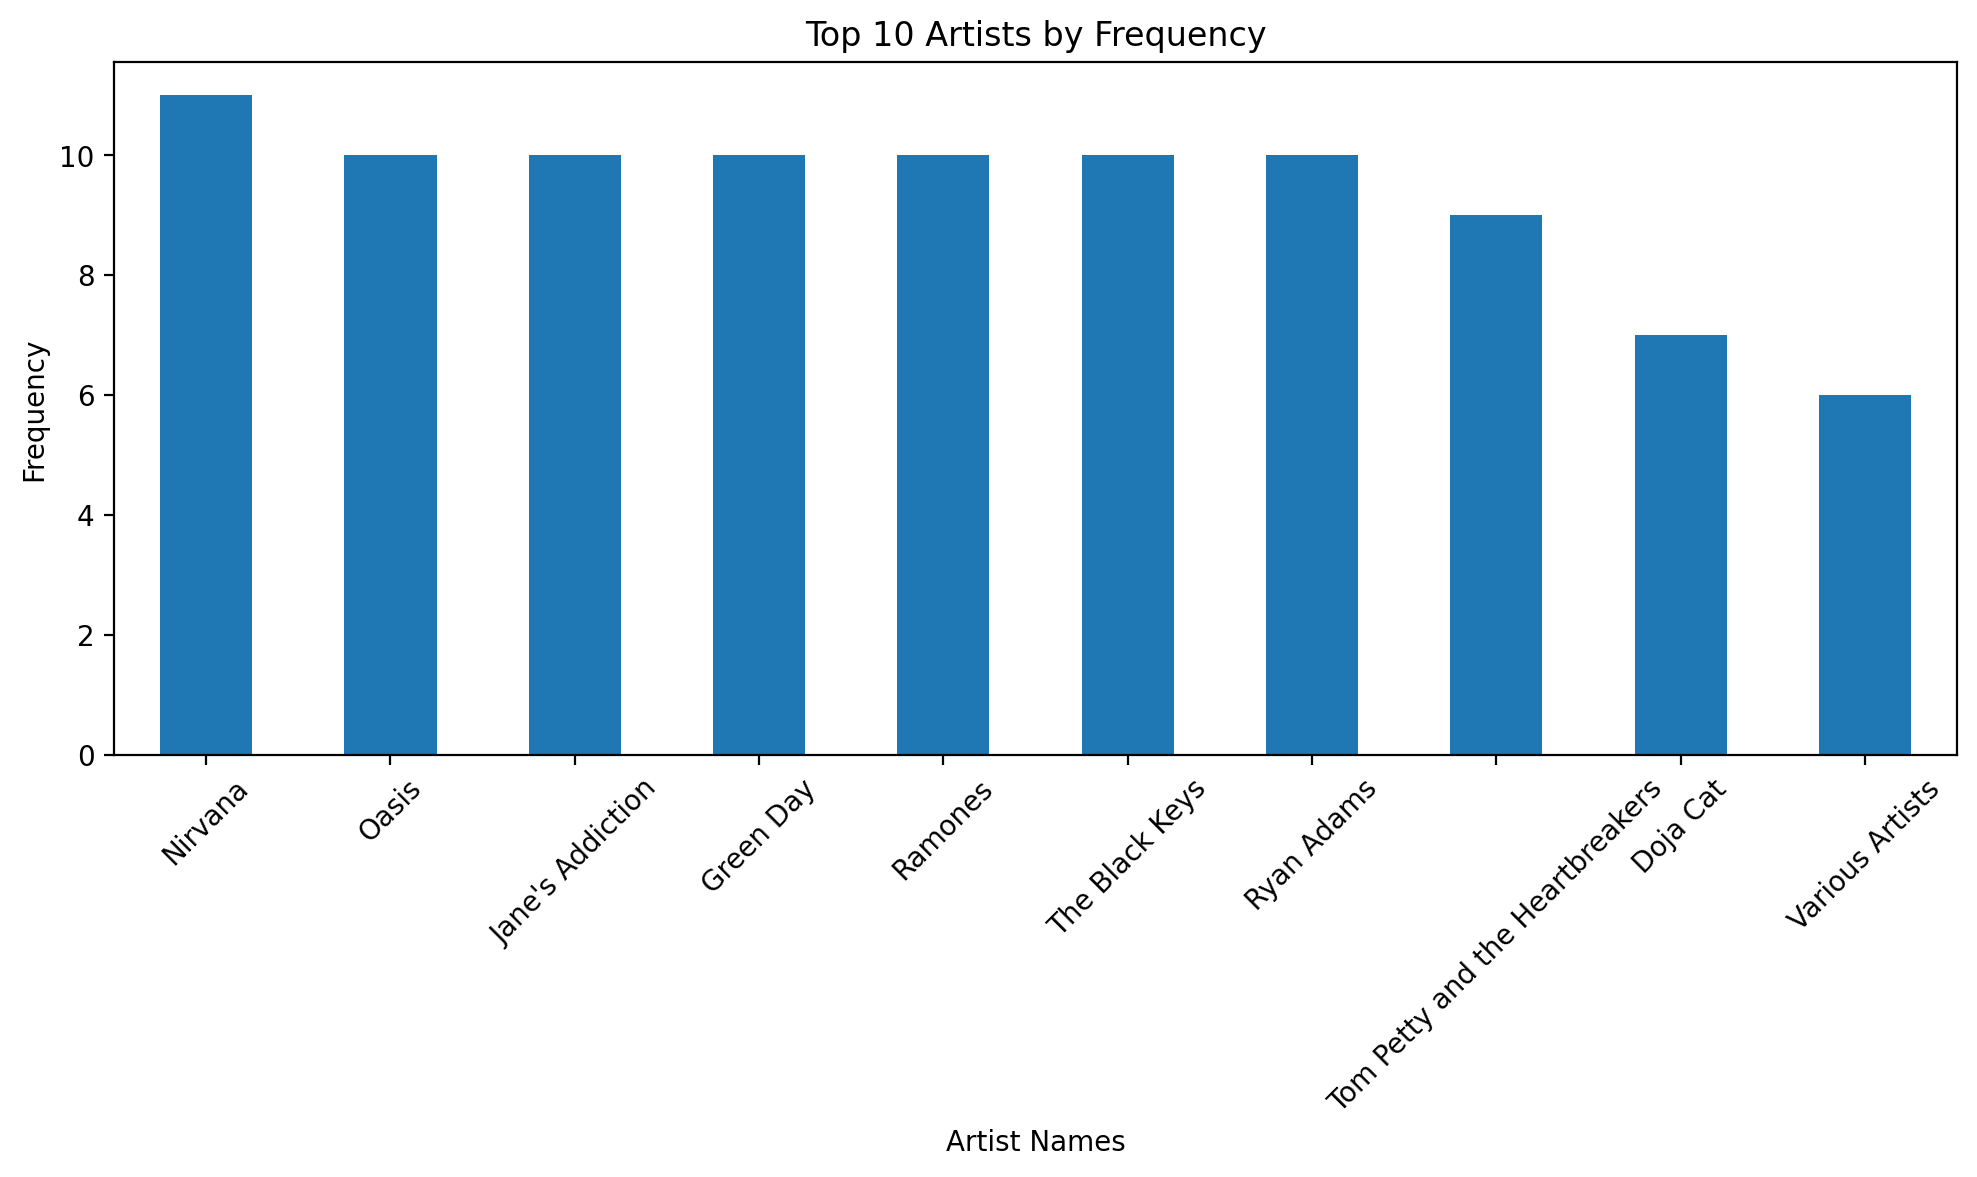

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your data into a DataFrame called 'df'

# Get the top 10 artists based on their frequency
top_10_artists = df['artist'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(10, 6))
top_10_artists.plot(kind='bar')
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.xlabel('Artist Names')
plt.ylabel('Frequency')
plt.title('Top 10 Artists by Frequency')
plt.tight_layout()
plt.show()

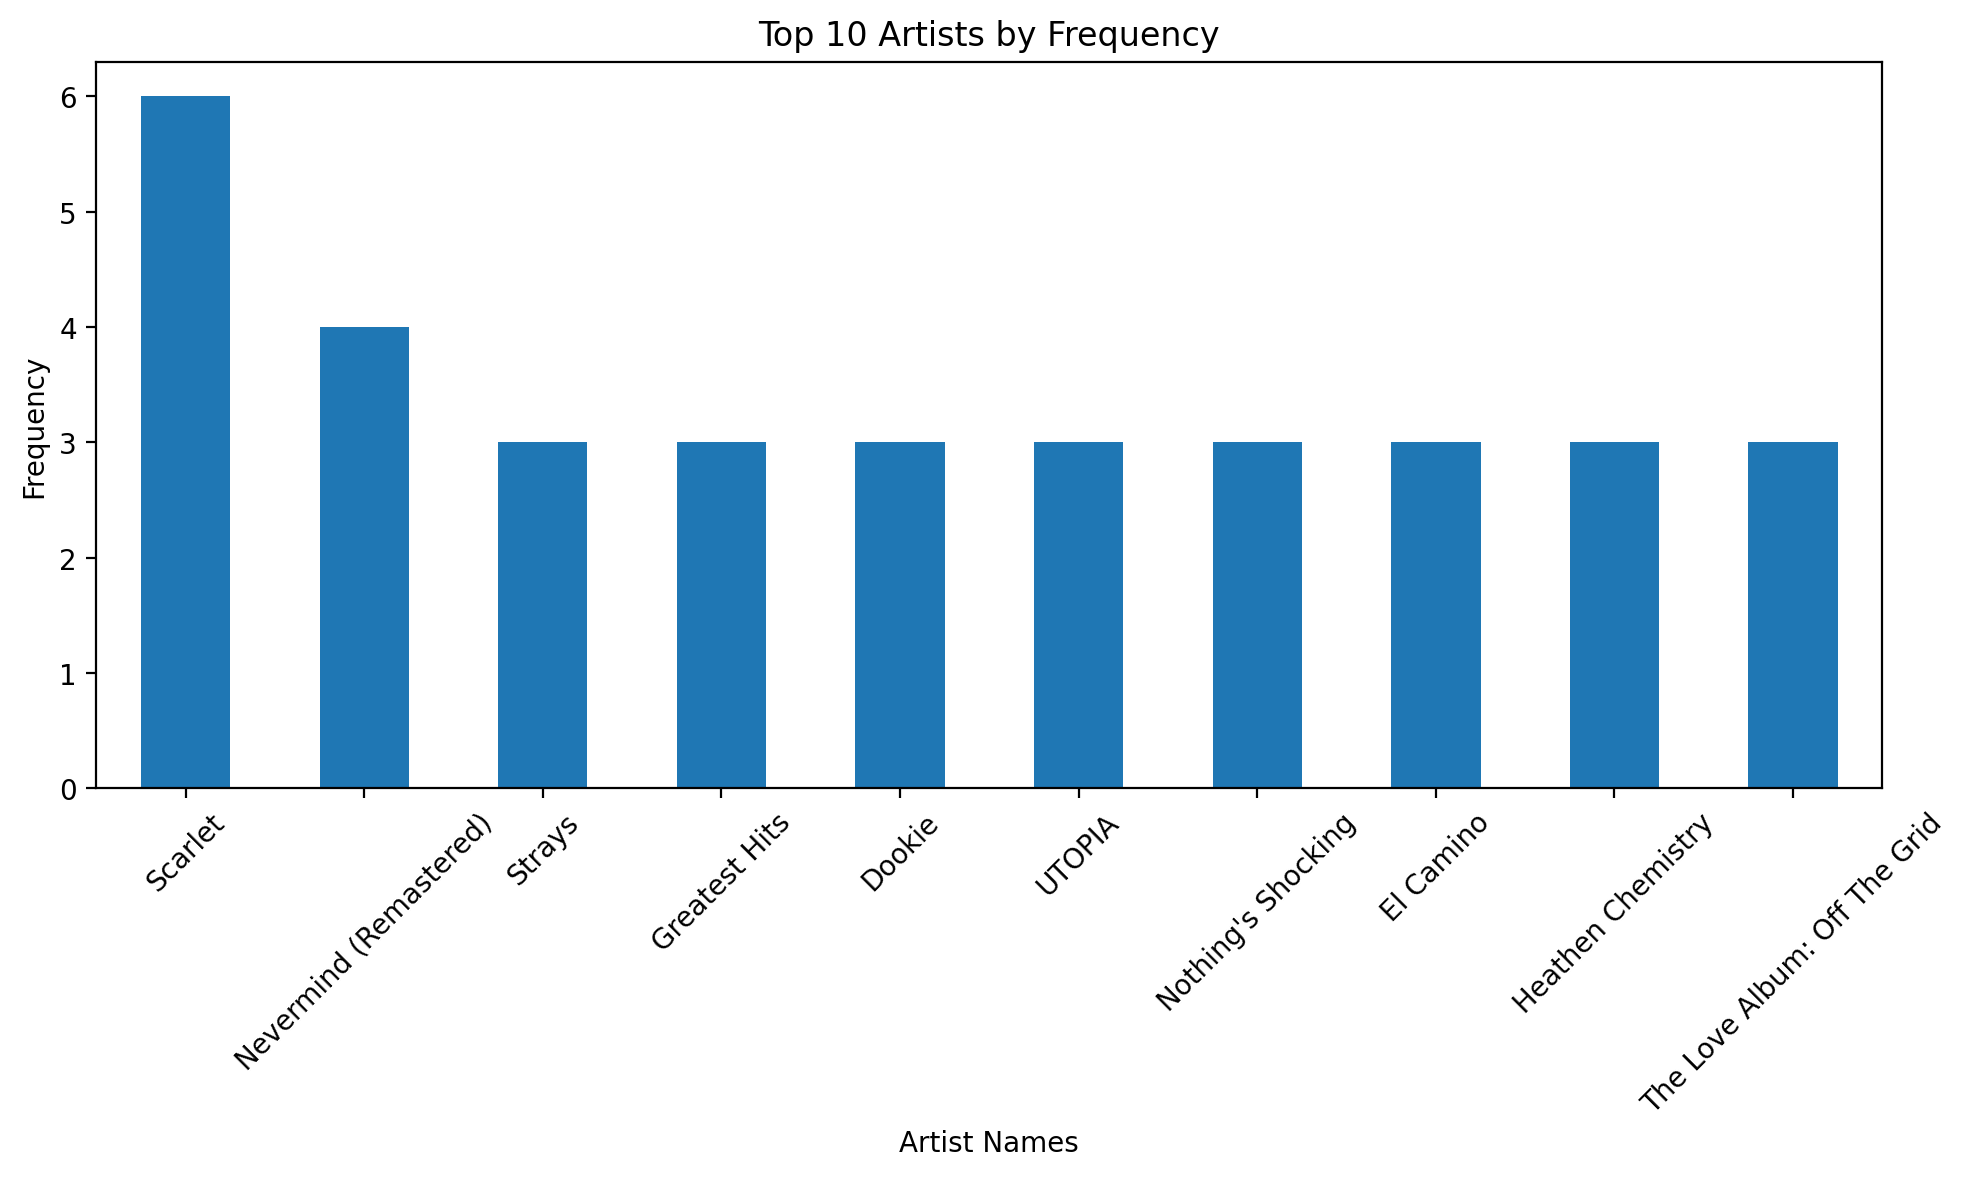

In [ ]:
# Get the top 10 artists based on their frequency
top_10_artists = df['album'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(10, 6))
top_10_artists.plot(kind='bar')
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.xlabel('Artist Names')
plt.ylabel('Frequency')
plt.title('Top 10 Artists by Frequency')
plt.tight_layout()
plt.show()

In [ ]:
def create_track_dataframe(results):
    track_name = []
    track_id = []
    artist = []
    album = []
    duration = []
    popularity = []
    
    for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

    df_favourite = pd.DataFrame({
        "track_name": track_name,
        "album": album,
        "track_id": track_id,
        "artist": artist,
        "duration": duration,
        "popularity": popularity
    })

    return df_favourite

# Example usage:
# Assuming you have your 'results' dictionary
# df = create_track_dataframe(results)
# df.head()


In [ ]:
# df.to_csv('playlist_songs.csv',index=False)
#df = pd.read_csv('data/playlist_songs.csv')
#df.head()

In [ ]:
# Getting top 50 tracks from user
results = sp.current_user_top_tracks(limit=1000, offset=0,time_range='short_term')
results_1 = sp.current_user_top_tracks(limit=1000, offset=0,time_range='medium_term')
results_2 = sp.current_user_top_tracks(limit=1000, offset=0,time_range='long_term')

#https://github.com/lognorman20/spotify_recommender/blob/main/data_engineering.ipynb

In [ ]:
short_term = create_track_dataframe(results)

In [ ]:
medium_term=create_track_dataframe(results_1)

In [ ]:
long_term = create_track_dataframe(results_2)

In [ ]:
long_term.head()

,track_name,album,track_id,artist,duration,popularity
0,Bad Boy (with Young Thug),Bad Boy (with Young Thug),43CIWpJaJHRcI4mUSjqgc2,Juice WRLD,157355,68
1,4U,4U,0G2OvqpvifsIHALlLqB5NG,Pi’erre Bourne,218000,42
2,Minute,Perfect Timing,3JWh19WsndEFg0UFRFeTiU,NAV,265373,62
3,Guillotine,The Life Of Pi'erre 4,7491l7CnemDkYH0jsoLvYr,Pi’erre Bourne,179890,53
4,Off The Map,After Me,6GNG0YQixWuLE0M5FtrRxY,SoFaygo,141582,57


In [ ]:
%%time
# Getting track features for each song in favorite song dataframe
fav_tracks = []
for track in short_term['track_id']:
    try:  
        track = getTrackFeatures(track)
        fav_tracks.append(track)
    except:
        pass

CPU times: total: 531 ms
Wall time: 11.8 s


In [ ]:
# Create favorite track wtih audio features dataset
df_fav = pd.DataFrame(fav_tracks, columns = ['track_id', 'name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
df_fav.head()

,track_id,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,5rfMpJorQrwpvCOfDM7Q5L,Wake Up,Wake Up,Dom Corleo,2023-03-31,112153,60,0.752,0.02420,0.411,0.00000,0.1680,-8.407,0.0965,137.037,4
1,302EsF6DE70LfngVNLlqo5,Fell In Love (with Ken Carson),TEC,Lil Tecca,2023-09-22,173195,72,0.630,0.00417,0.695,0.00000,0.1170,-5.740,0.0592,139.959,4
2,05grSYrVwYw58YMOdJceyz,Patience (feat. Don Toliver),Pink Tape,Lil Uzi Vert,2023-06-30,262429,68,0.706,0.08600,0.640,0.00000,0.5370,-3.146,0.2030,143.905,4
3,0xl1w2q4VLojeXp4JfazPL,Sacrifices,More Life,Drake,2017-03-18,307593,61,0.903,0.04070,0.439,0.00000,0.1380,-11.813,0.3970,139.112,4
4,3N3d4OWbPVxTQVBFqNyykk,Down Hill,"Honestly, Nevermind",Drake,2022-06-17,250864,57,0.718,0.96500,0.319,0.00036,0.0895,-11.261,0.0435,109.994,4


In [ ]:
# Dropping columns that could lead to data leakage
df_test= df_fav.drop(columns=['track_id','name', 'album', 'artist', 'release_date'])
df_test.head()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   length            50 non-null     int64  
 1   popularity        50 non-null     int64  
 2   danceability      50 non-null     float64
 3   acousticness      50 non-null     float64
 4   energy            50 non-null     float64
 5   instrumentalness  50 non-null     float64
 6   liveness          50 non-null     float64
 7   loudness          50 non-null     float64
 8   speechiness       50 non-null     float64
 9   tempo             50 non-null     float64
 10  time_signature    50 non-null     int64  
dtypes: float64(8), int64(3)
memory usage: 4.4 KB


In [ ]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)

corr = df_test.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
length,1.000000,0.165963,0.215360,-0.105646,0.289537,-0.120255,-0.051241,0.191816,0.026681,-0.077059,-0.021929
popularity,0.165963,1.000000,-0.085427,-0.028534,0.063541,-0.166759,0.092815,0.037663,-0.212032,-0.130854,-0.029134
danceability,0.215360,-0.085427,1.000000,-0.233147,0.117652,-0.407388,-0.217536,0.314649,0.524224,0.085261,0.306037
acousticness,-0.105646,-0.028534,-0.233147,1.000000,-0.604188,0.288791,-0.169414,-0.560489,-0.100339,-0.163018,-0.209901
energy,0.289537,0.063541,0.117652,-0.604188,1.000000,-0.385949,0.130620,0.757854,0.023387,0.173196,0.249392
instrumentalness,-0.120255,-0.166759,-0.407388,0.288791,-0.385949,1.000000,-0.124851,-0.581829,-0.321346,-0.142547,-0.335750
liveness,-0.051241,0.092815,-0.217536,-0.169414,0.130620,-0.124851,1.000000,0.168858,0.024811,-0.192602,0.083543
loudness,0.191816,0.037663,0.314649,-0.560489,0.757854,-0.581829,0.168858,1.000000,0.186008,0.138470,0.356440
speechiness,0.026681,-0.212032,0.524224,-0.100339,0.023387,-0.321346,0.024811,0.186008,1.000000,0.187568,0.110161
tempo,-0.077059,-0.130854,0.085261,-0.163018,0.173196,-0.142547,-0.192602,0.138470,0.187568,1.000000,0.058642


In [ ]:
# Dropping columns that could lead to data leakage
df_test1= df.drop(columns=['track_id','name', 'album', 'artist', 'release_date'])

rs = np.random.RandomState(0)
corr = df_test1.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps


,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
length,1.000000,0.064023,-0.168219,-0.059517,0.106633,-0.134623,0.092531,0.076661,0.051589,-0.110962,0.009475
popularity,0.064023,1.000000,0.028316,-0.144595,0.095557,-0.026258,-0.159791,0.164445,-0.372128,0.029694,-0.007393
danceability,-0.168219,0.028316,1.000000,-0.083171,-0.106006,-0.203839,-0.042076,0.069494,0.269366,-0.165378,0.066055
acousticness,-0.059517,-0.144595,-0.083171,1.000000,-0.660489,0.291736,-0.098106,-0.623535,0.121893,-0.131164,-0.206460
energy,0.106633,0.095557,-0.106006,-0.660489,1.000000,-0.321269,0.204802,0.779348,-0.096621,0.182045,0.158192
instrumentalness,-0.134623,-0.026258,-0.203839,0.291736,-0.321269,1.000000,-0.063288,-0.520884,-0.130967,-0.045974,-0.032528
liveness,0.092531,-0.159791,-0.042076,-0.098106,0.204802,-0.063288,1.000000,0.106338,0.159286,0.063751,0.024990
loudness,0.076661,0.164445,0.069494,-0.623535,0.779348,-0.520884,0.106338,1.000000,-0.133399,0.125797,0.110480
speechiness,0.051589,-0.372128,0.269366,0.121893,-0.096621,-0.130967,0.159286,-0.133399,1.000000,-0.064889,0.032537
tempo,-0.110962,0.029694,-0.165378,-0.131164,0.182045,-0.045974,0.063751,0.125797,-0.064889,1.000000,0.000141


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


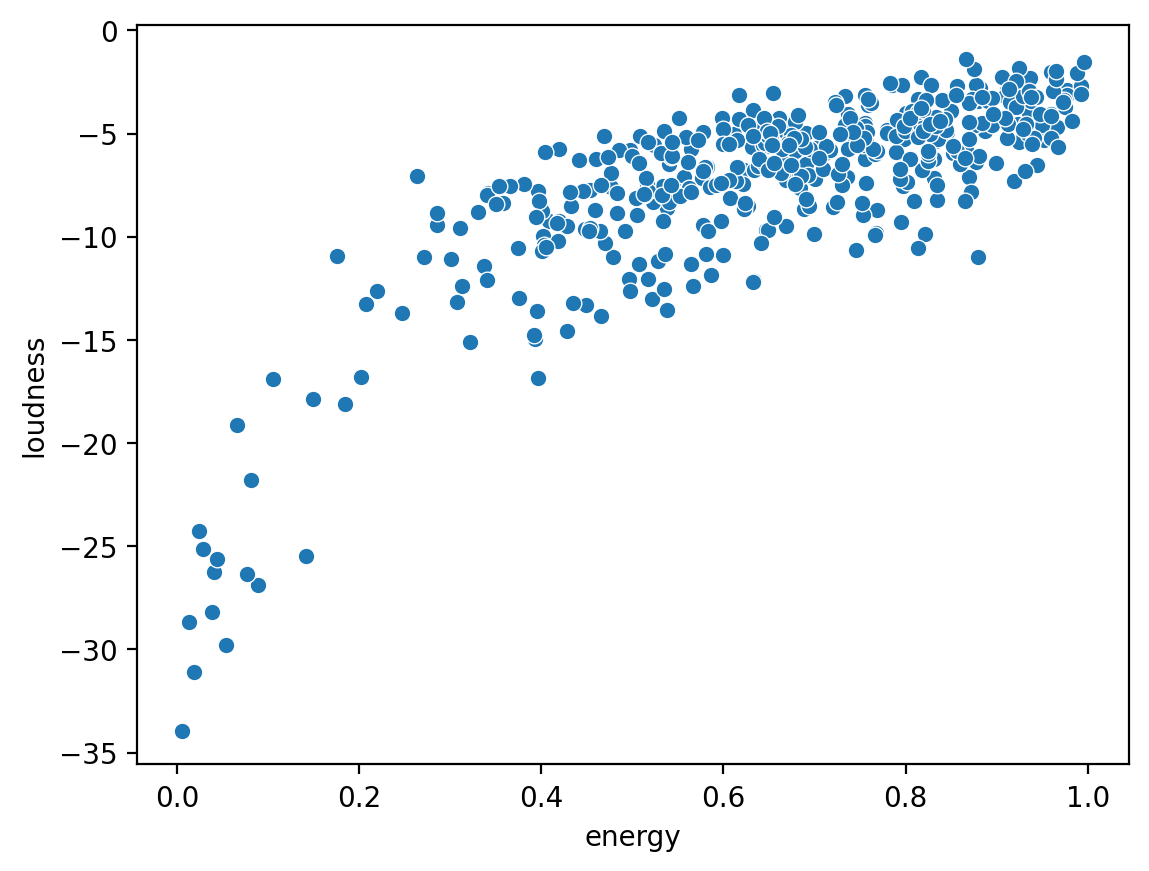

In [ ]:
sns.scatterplot(x='energy', y='loudness', data=df_test1)
plt.show()

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instea

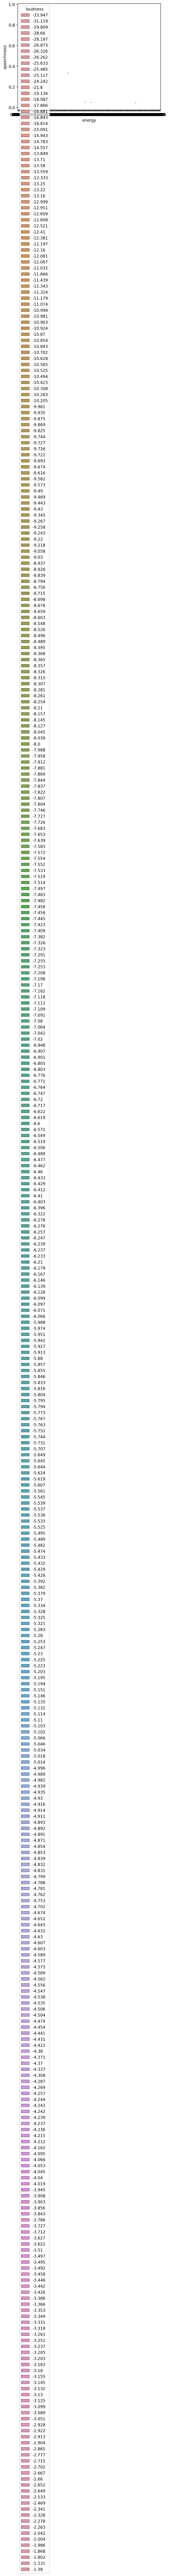

In [ ]:
'''
sns.violinplot(x='energy', y='speechiness', hue='loudness', data=df_test1)
plt.show()

'''